In [138]:
import cv2
import numpy as np
import pandas as pd

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

import glob
from itertools import product
from os.path import join, basename, exists
from os import makedirs

In [100]:
img = cv2.imread('../../data/segmentation/train/A14OK5A65AR5AOST/A14OK5A65AR5AOST.png')[..., ::-1]
mask = cv2.imread('../../data/segmentation/train/A14OK5A65AR5AOST/A14OK5A65AR5AOST_mask.png')

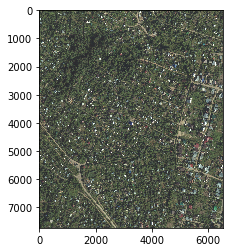

In [101]:
imshow(img)

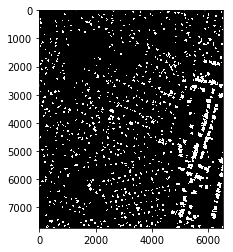

In [102]:
imshow(mask)

In [103]:
img.shape, mask.shape

((7736, 6523, 3), (7736, 6523, 3))

In [110]:
img.shape[0] / 224, img.shape[1] / 224

(34.535714285714285, 29.120535714285715)

In [105]:
H_SIZE, W_SIZE = (512, 512)

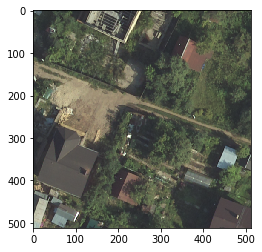

In [106]:
i, j = 5, 9
imshow(img[i * H_SIZE:i * H_SIZE + H_SIZE, j * W_SIZE:j * W_SIZE + W_SIZE])

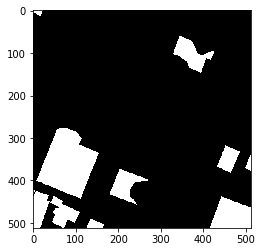

In [107]:
imshow(mask[i * H_SIZE:i * H_SIZE + H_SIZE, j * W_SIZE:j * W_SIZE + W_SIZE])

In [89]:
# !rm -r ../../data/segmentation/patches_224x224/

In [90]:
H_SIZE, W_SIZE = (224, 224)
pd_dict = {'img_path': [], 'mask_path': []}
mask_paths = glob.glob('../../data/segmentation/train/*/*_mask.png')
output_folder = '../../data/segmentation/patches_224x224/'

if not exists(output_folder):
    makedirs(output_folder)

for mask_path in tqdm(mask_paths):
    img_path = mask_path[:-9] + '.png'
    
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    n_rows, n_cols = mask.shape[0] // H_SIZE, mask.shape[1] // W_SIZE
    
    for i, j in product(range(n_rows), range(n_cols)):
        patch = img[i * H_SIZE:i * H_SIZE + H_SIZE, j * W_SIZE:j * W_SIZE + W_SIZE]
        patch_mask = mask[i * H_SIZE:i * H_SIZE + H_SIZE, j * W_SIZE:j * W_SIZE + W_SIZE]
        
        b_img_path = basename(img_path)[:-4] + '_' + str(i) + '_' + str(j) + '.png'
        b_mask_path = basename(mask_path)[:-9] + '_' + str(i) + '_' + str(j) + '_mask.png'
        patch_path = join(output_folder, b_img_path)
        patch_mask_path = join(output_folder, b_mask_path)
        
        cv2.imwrite(patch_path, patch)
        cv2.imwrite(patch_mask_path, patch_mask)
        pd_dict['img_path'].append(b_img_path)
        pd_dict['mask_path'].append(b_mask_path)


100%|██████████| 10/10 [01:01<00:00,  6.27s/it]


In [91]:
data = pd.DataFrame(pd_dict)
data.to_csv('../../data/segmentation/all.csv', index=False)

In [94]:
pd.read_csv('../../data/segmentation/all.csv').shape

(9860, 2)

### Random Crop Dataset

In [171]:
data = []
mask_paths = glob.glob('/home/ubuntu/data/segmentation/train/*/*_mask.png')
for mask_path in mask_paths:
    row = {}
    row['mask_path'] = mask_path
    row['img_path'] = mask_path[:-9] + '.png'
    
    if row:
        data.append(row)

data = pd.DataFrame(data)

In [172]:
data.to_csv('../../data/segmentation/rnd_crops/all.csv', index=False)

In [115]:
from torch.utils.data import Dataset

In [151]:
class RandomCropDataset(Dataset):
    def __init__(self, labels, 
                 image_column, mask_column, 
                 images_folder, masks_folder,
                 h_size, w_size, rnd_crop, crop_range,
                 transform=None):
        
        self.transform = transform
        self.labels = labels
        self.image_column = image_column
        self.mask_column = mask_column
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.h_size = h_size
        self.w_size = w_size
        self.rnd_crop = rnd_crop
        self.crop_range = crop_range
        
        self.images = []
        self.masks = []
        self.count = 0
        
#         labels = pd.read_csv(labels)
        for row in labels.iterrows():
            img_path = row[1][image_column]
            mask_path = row[1][mask_column]
            
            img = cv2.imread(img_path)[..., ::-1]
            mask = cv2.imread(mask_path)[..., 0]
            
            self.images.append(img)
            self.masks.append(mask)
            self.count += 1
        
        self.n_rows = mask.shape[0] // h_size
        self.n_cols = mask.shape[1] // w_size

    def process_new_item(self, index):
        img_idx = index // (self.n_rows * self.n_cols)
        pidx = index - img_idx * (self.n_rows * self.n_cols)
        
        img = self.images[img_idx]
        mask = self.masks[img_idx]
        
        if not self.rnd_crop:
            row_idx = pidx // n_cols
            col_idx = pidx % n_cols
        
            img_p = img[row_idx * self.h_size: row_idx * self.h_size + self.h_size,
                        col_idx * self.w_size: col_idx * self.w_size + self.w_size]
            mask_p = mask[row_idx * self.h_size: row_idx * self.h_size + self.h_size,
                          col_idx * self.w_size: col_idx * self.w_size + self.w_size]
            
#             d_mask = np.zeros_like(mask)
#             d_mask[row_idx * self.h_size: row_idx * self.h_size + self.h_size,
#                    col_idx * self.w_size: col_idx * self.w_size + self.w_size] = 255
#             imshow(d_mask)
        else:
            size = np.random.randint(self.crop_range[0], self.crop_range[1])
            x = np.random.randint(0, self.n_rows * self.h_size - size)
            y = np.random.randint(0, self.n_cols * self.w_size - size)
            
            img_p = img[x:x + size, y: y + size]
            mask_p = mask[x:x + size, y: y + size]
            
#             d_mask = np.zeros_like(mask)
#             d_mask[x:x + size, y: y + size] = 255
#             imshow(d_mask)
        
        if self.transform is not None:
            augmented = self.transform(image=img_p, mask=mask_p)
            img_p = augmented['image']
            mask_p = augmented['mask']

        sample = {'image': img_p,
                  'mask': mask_p
                 }

        return sample

    def __getitem__(self, index):
        result = self.process_new_item(index)
        return result

    def __len__(self):
        return self.n_rows * self.n_cols * self.count

In [155]:
dataset = RandomCropDataset(data, 'img_path', 'mask_path',
                  '../../data/segmentation/train/', '../../data/segmentation/train/',
                  224, 224, True, [100, 500])

In [156]:
len(dataset)

9860

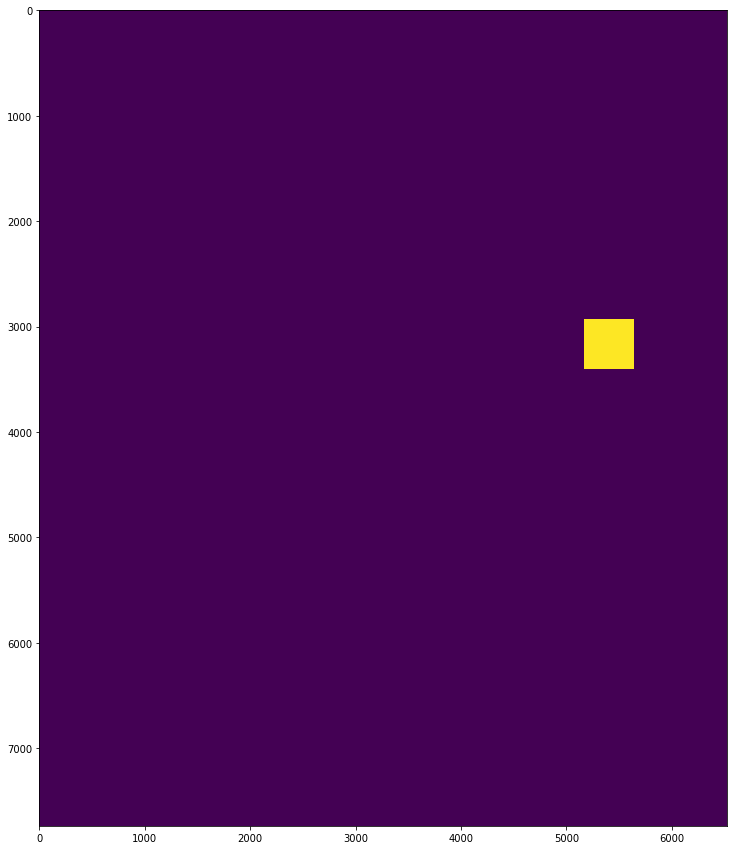

In [161]:
plt.figure(figsize=(15, 15))
dataset[0]['mask'];